# Calibration of IMU on a turntable

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
import pyins

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 12

In this example it is demonstrated how a standard IMU calibration on a simulated turntable can be performed.

## IMU measurement model and calibration procedure

First let's describe the model of IMU measurements. For both gyros and accelerometers it has the form
$$
\tilde{x} = T x + b + n
$$
Where 
- $x$ - true kinematic vector (angular rate or specific force) resolved in the reference body frame 
- $\tilde{x}$ - measured vector
- $T$ - transform matrix close to identity: diagonal elements define scale factor error and off-diagonal elements define axes misalignments
- $b$ - bias vector, which in this context assumed to be constant, in a sense that it's the most significant constant part of the changing bias
- $n$ - noise and unaccounted effects

Here we consider IMUs of MEMS type, which tend to have significant noises, random and temperature bias instabilities. 
For precise IMUs the approach in principle will be the same, but more nuansed in handling biases.

The method of calibration differs for gyros and accelerometers.

### For gyros

The bias vector is not precicely estimated in the process, because usually it must be measured over the temperature range and it won't be very stable anyway.
But it is roughly estimated and eliminated to get correct estimates of the transform matrix

The calibration procedure is repeated for each of 3 axis:

- Keep the IMU at rest for 30-60 seconds and estimate the current gyro biases (plus Earth angular rate) as their average readings
- Rotate the IMU around the axis by 360 degrees (other angles are possible) with significant angular rate (20-50 deg/s). Compute the integrals after bias compensation and divide by 360 degrees (or radian sequivalent) to get a column of the transform matrix


### For accelerometers

The bias measurement is inherent to the accelerometer calibration process. 
Moreover often accelerometers have less bias sensitivity to the temperature change and the single bias value might be appropriate.

The calibration is done by putting each IMU axis vertically up and down and computing half sums and half differences of the averaged readings to get transform matrix elements and biases. 
The exact computations can be seen in the code.


The whole calibration procedure will be executed using `pyins.sim.Turnable` class.

## Executing calibration procedure

First we need to performe rotation commands and generate ideal IMU readings corresponding to the motion.
Segments which will be used for the calibration will be specifically labeled (using `label=...`).

In [2]:
table = pyins.sim.Turntable()

# Gyro calibration

# x-axis
table.rest(30, label='gyro_bias_x')
table.rotate('outer', 360, label='gyro_rot_x')

# z-axis
table.rest(30, label='gyro_bias_z')
table.rotate('inner', 360, label='gyro_rot_z')
table.rest(5)

# y-axis
table.rotate('inner', -90)
table.rest(30, label='gyro_bias_y')
table.rotate('outer', 360, label='gyro_rot_y')
table.rest(5)

# Accelerometer calibration

# z-axis
table.rest(10, label='accel_z_down')
table.rotate('outer', 180)
table.rest(10, label='accel_z_up')

# y-axis
table.rotate('outer', 90)
table.rest(10, label='accel_x_down')
table.rotate('outer', 180)
table.rest(10, label='accel_x_up')

# x-axis
table.rotate('inner', 90)
table.rest(10, label='accel_y_down')
table.rotate('inner', 180)
table.rest(10, label='accel_y_up')

Generate ideal IMU data.

Let's assume that table is slightly non-horizontal and there is small non-orthgonality between its axes (on the level of arcseconds).
The heading angle is arbitrary.

In [3]:
table_lla = [55, 58, 0]
table_rph = [-2/3600, 1/3600, 137]

trajectory, imu_ideal, labels = table.generate_imu(0.01, [55, 58, 0], table_rph, 3/3600)

Now let's define IMU error parameters (generate randomly given statistical model).

In [4]:
gyro_model = pyins.inertial_sensor.EstimationModel(
    bias_sd=400 * pyins.transform.DH_TO_RS, 
    noise=1 * pyins.transform.DRH_TO_RRS,
    bias_walk=20 * pyins.transform.DH_TO_RS / 60,
    scale_misal_sd=0.01
)
accel_model = pyins.inertial_sensor.EstimationModel(
    bias_sd=0.2,
    noise=0.1 / 60,
    bias_walk=0.003 / 60,
    scale_misal_sd=0.01
)
rng = np.random.RandomState(0)
gyro_parameters = pyins.inertial_sensor.Parameters.from_EstimationModel(gyro_model, rng)
accel_parameters = pyins.inertial_sensor.Parameters.from_EstimationModel(accel_model, rng)

And apply parameters to get the final IMU readings:

In [5]:
imu = pyins.inertial_sensor.apply_imu_parameters(imu_ideal, 'rate', 
                                                 gyro_parameters, accel_parameters)

Let's plot IMU readings to demonstrate how calibration procedure is organized.

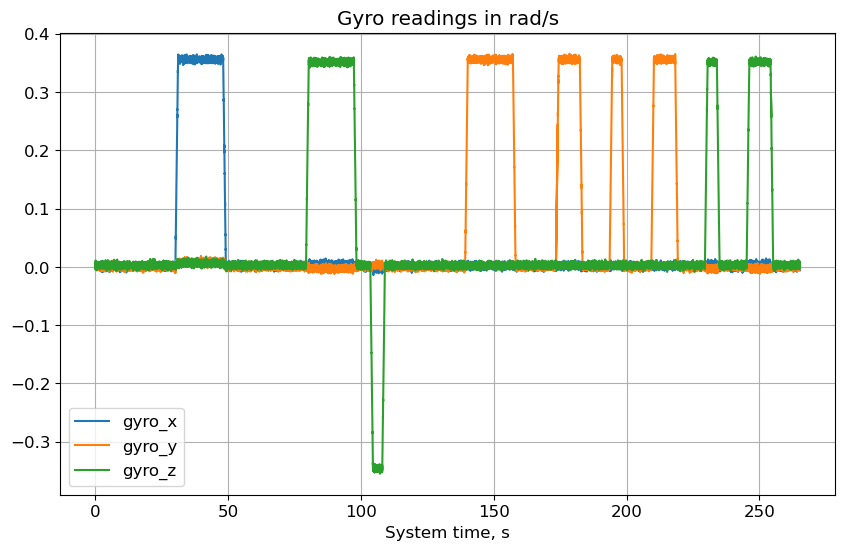

In [6]:
plt.plot(imu[pyins.util.GYRO_COLS], label=['gyro_x', 'gyro_y', 'gyro_z'])
plt.xlabel("System time, s")
plt.title("Gyro readings in rad/s")
plt.legend()

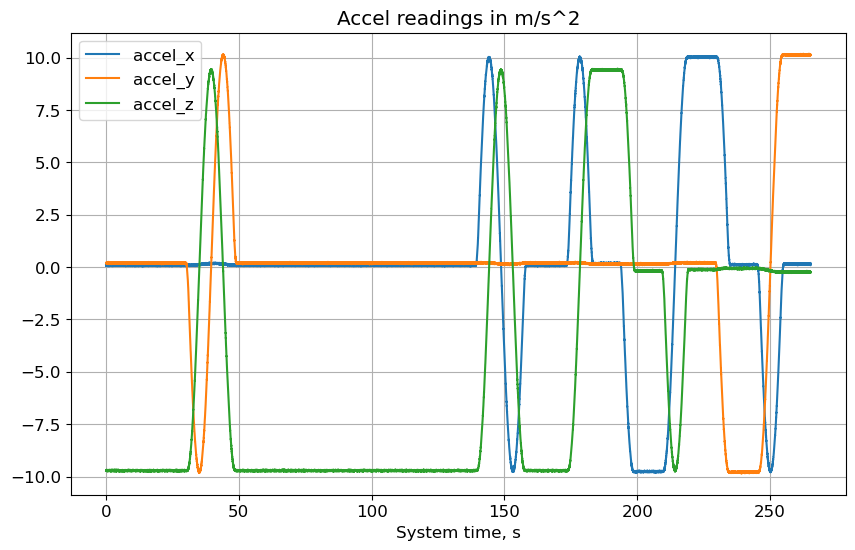

In [7]:
plt.plot(imu[pyins.util.ACCEL_COLS], label=['accel_x', 'accel_y', 'accel_z'])
plt.xlabel("System time, s")
plt.title("Accel readings in m/s^2")
plt.legend()

## Computing calibration parameters

Now the data is ready to estimate IMU calibration parameters.

### For gyros

We estimate only the transform matrix.

In [8]:
def estimate_gyro_transform_column(bias, rotation, angle):
    bias = np.mean(bias, axis=0)
    return trapezoid(rotation - bias, rotation.index, axis=0) / angle

In [9]:
gyro = imu[pyins.util.GYRO_COLS]

In [10]:
T_gyro = np.array([
    estimate_gyro_transform_column(gyro[labels == 'gyro_bias_x'], 
                                   gyro[labels == 'gyro_rot_x'], 2 * np.pi),
    estimate_gyro_transform_column(gyro[labels == 'gyro_bias_y'], 
                                   gyro[labels == 'gyro_rot_y'], 2 * np.pi),
    estimate_gyro_transform_column(gyro[labels == 'gyro_bias_z'], 
                                   gyro[labels == 'gyro_rot_z'], 2 * np.pi),
]).transpose()

### For accelerometers

Compute gravity magnitude at the site.

In [11]:
g = pyins.earth.gravity(table_lla[0], table_lla[2])

In [12]:
accel = imu[pyins.util.ACCEL_COLS]

In [13]:
def estimate_accel(up, down, g):
    up = np.mean(up.values, axis=0)
    down = np.mean(down.values, axis=0)    
    return 0.5 * (up - down) / g, 0.5 * (up + down)

We estimate the transform matrix and also get 3 independed estimates of the bias vector (at different times 
though).
The final bias estimate is taked as average.

In [14]:
T_accel_x, b1 = estimate_accel(accel[labels == 'accel_x_up'], 
                               accel[labels == 'accel_x_down'], g)

T_accel_y, b2 = estimate_accel(accel[labels == 'accel_y_up'], 
                               accel[labels == 'accel_y_down'], g)

T_accel_z, b3 = estimate_accel(accel[labels == 'accel_z_up'], 
                               accel[labels == 'accel_z_down'], g)

In [15]:
T_accel = np.array([T_accel_x, T_accel_y, T_accel_z]).transpose()
b_accel = (b1 + b2 + b3) / 3

## Comparison with truth values

Now let's compare the estimated parameters with ground truth values.

In [16]:
T_gyro_error = (T_gyro - gyro_parameters.transform) * 100

In [17]:
T_gyro_error

array([[-0.02260946, -0.03128734, -0.04421609],
       [-0.00387743, -0.02768793,  0.02209065],
       [ 0.03555818,  0.02455051,  0.0025571 ]])

Gyro transform matrix errors don't exceed 0.05% (in the absolute sense).

In [18]:
T_accel_error = (T_accel - accel_parameters.transform) * 100

In [19]:
T_accel_error

array([[ 4.31180933e-03,  5.98496818e-03, -1.25831036e-03],
       [-1.80979844e-03, -9.89597463e-05, -2.59689687e-03],
       [-4.45354824e-03, -8.61093170e-03,  1.25015751e-03]])

The accelerometer transform matrix errors don't exceed 0.01%. 
It is better than errors for the gyro matrix because there are no approximations involved (other than constant bias assumptions). 
And the modeled table imperfections are not significant.

For the true bias let's take the average value over the whole time.

In [20]:
b_accel_true = accel_parameters.data_frame[['bias_x', 'bias_y', 'bias_z']].mean(axis=0).values
b_accel_error = b_accel - b_accel_true

In [21]:
b_accel_error

array([-0.00028727, -0.00030119, -0.00019668])

Accelerometer bias errors (in somewhat arbitrary sense) don't exceed 0.0005 m/s^2.